# INTERESTING MATCHING POINTS

### SIFT vs SuperPoint vs SuperPoint+SuperGlue on the POLAR Dataset

In this notebook I evaluate 3 different methods for interest point detection and matching on lunar-like terrain images: **SIFT**, a classical computer vision algorithm, and **SuperPoint**, a modern deep-learning-based feature extractor and **Superpoin+SuperGlue**. 

**What is the problem?**  
Feature matching on lunar imagery is challenging due to extreme illumination variations (deep shadows, backlighting, high contrast). These conditions significantly affect the stability of keypoints and descriptors.

**Why is it important?**  
Robust feature matching is a fundamental step in the reconstruction of Digital Elevation Models (DEMs), visual navigation, and terrain mapping for lunar exploration missions.

**What methods are we comparing?**  
- **SIFT** for classical, geometry-driven features  
- **SuperPoint** for learned feature extraction  
- **SuperGlue** for learned correspondence refinement

**What is the goal of the work?**  
To evaluate and compare the robustness of these methods under illumination and viewpoint changes, using sample data from the **NASA POLAR Traverses** dataset, which simulates lunar polar lighting conditions.


## Experimental Setup

To evaluate the robustness of SIFT, SuperPoint, and SuperPoint+SuperGlue, we design two controlled experimental scenarios using images from the NASA POLAR Traverses dataset. Each scenario isolates a specific difficulty commonly encountered in lunar imagery.

### 1. Same Viewpoint, Different Exposure
This scenario measures robustness to **illumination variation only**, with no geometric changes.  
For each exposure pair within the same traverse location (`loc00m`), we extract features, compute matches, and estimate geometric inliers through RANSAC. This provides a baseline for understanding how each method handles extreme lighting conditions.

### 2. Stereo Viewpoint, Different Exposure
This more challenging setup combines **viewpoint change** with **illumination variation**.  
We evaluate image pairs captured from slightly different rover positions with different exposure values. This scenario reflects realistic conditions for DEM reconstruction and visual navigation, where both geometry and lighting vary simultaneously.

### Evaluation Metric: Inlier Ratio
For each image pair:
1. Detect keypoints  
2. Compute descriptors  
3. Perform feature matching  
4. Use RANSAC to identify geometrically consistent correspondences  

The final metric is the **inlier ratio**:

$$
\text{inlier ratio} = \frac{\text{number of inliers}}{\text{number of raw matches}}
$$

This metric captures both descriptor quality (match correctness) and geometric stability (consistency under RANSAC).

### Output
For each method and scenario, we build a **heatmap matrix** representing the inlier ratio between all exposure/viewpoint combinations. These heatmaps allow direct comparison of robustness across conditions.


## Key Findings

- **SIFT**  
  SIFT shows strong robustness to viewpoint changes thanks to its geometric invariance.  
  However, its performance drops under severe illumination variation, especially across extreme exposure differences.

- **SuperPoint**  
  SuperPoint is highly robust to illumination changes when the viewpoint is fixed, achieving high inlier ratios across most exposure combinations.  
  Its main limitation emerges with viewpoint variation, where performance decreases sharply due to limited geometric invariance.

- **SuperPoint + SuperGlue**  
  SuperGlue significantly improves correspondence stability for SuperPoint under illumination changes.  
  Nonetheless, even with SuperGlue, large viewpoint differences remain challenging, and SIFT still performs better in wide-baseline scenarios.

**Overall**, learned features (SuperPoint) excel in photometric robustness, while classical SIFT remains more reliable under geometric variation.  
No method dominates in all conditions, highlighting the importance of choosing the appropriate pipeline depending on the mission scenario (illumination vs. viewpoint change).

### Future Improvements

- Using additional sequences from the POLAR dataset (or other lunar-analog datasets) would help assess how performance generalizes across terrains and lighting conditions.

- Include additional feature-matching methods (e.g., ORB, R2D2, D2-Net, ALIKED) to broaden the comparison between classical, hybrid, and modern learned approaches.

- Incorporate additional quantitative metrics (e.g., repeatability, matching precision/recall, or pose-estimation error) to support a more complete and objective comparison between methods.


## DATASET

The experiments in this notebook use images from the **NASA POLAR** dataset, a lunar-analog imaging dataset designed to reproduce the extreme illumination conditions found near the Moon’s south pole.  
POLAR provides high-resolution grayscale images captured under different exposure settings and from slightly different viewpoints along a traverse.  

### Why this dataset?

The POLAR dataset is ideal for this study because it reproduces the extreme lighting conditions encountered in lunar polar regions, including deep shadows, strong backlighting, and high-contrast transitions.  
These conditions are known to cause failures in keypoint detection and matching pipelines, making POLAR a realistic testbed for evaluating robustness.  

Unlike generic computer vision datasets, POLAR:

- contains controlled **exposure variations**, allowing systematic illumination tests  
- provides **slightly shifted viewpoints** captured along rover traverses  
- simulates **terrain and lighting challenges** relevant to lunar DEM reconstruction and visual navigation  
- aligns with real mission conditions investigated by ESA and NASA  

This makes POLAR not only suitable, but *highly relevant* for assessing feature matching algorithms in a lunar exploration context.


Show image sample:

In [105]:
import cv2
import matplotlib.pyplot as plt

def show_image(path):
    img = cv2.imread(path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img, cmap="gray")
    plt.title(path)
    plt.axis("off")
    plt.show()

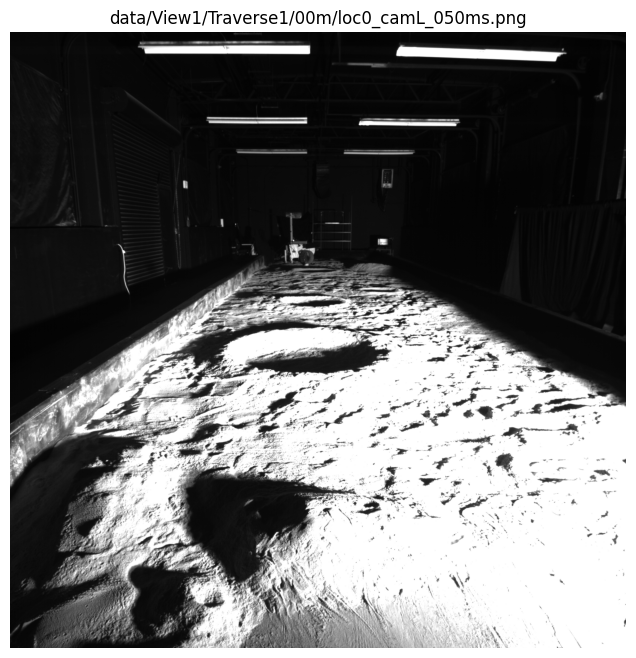

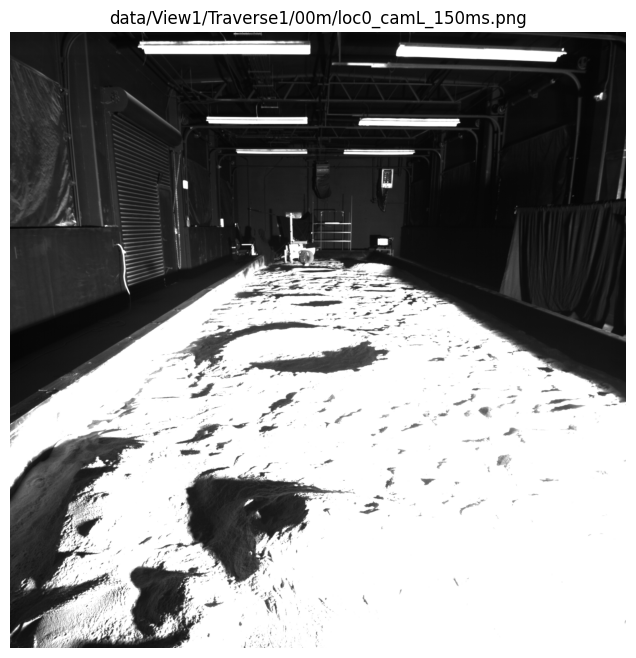

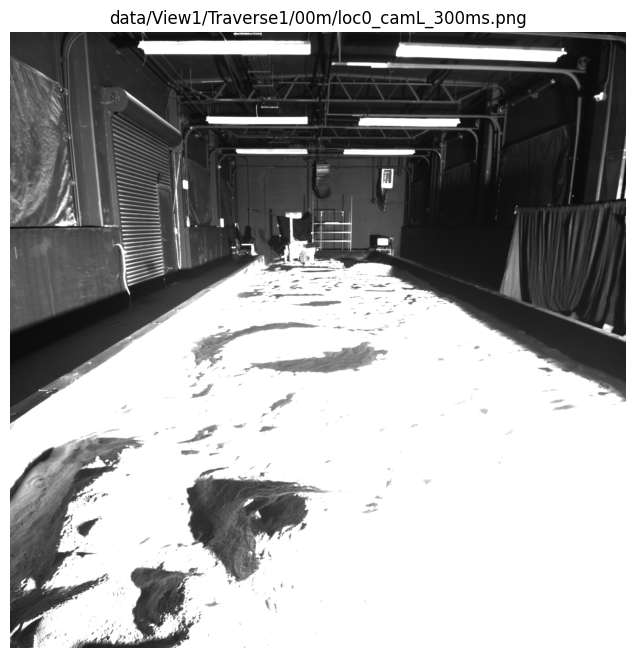

In [106]:
show_image("data/View1/Traverse1/00m/loc0_camL_050ms.png")
show_image("data/View1/Traverse1/00m/loc0_camL_150ms.png")
show_image("data/View1/Traverse1/00m/loc0_camL_300ms.png")

## SIFT

### Theoretical Background: How SIFT Works

#### 1. Scale-space
SIFT detects features across multiple image scales.  
The scale-space is built by convolving the image with Gaussians of increasing σ:

$$
L(x,y,\sigma) = G(x,y,\sigma) * I(x,y)
$$

where:

$$
G(x,y,\sigma)=\frac{1}{2\pi\sigma^2} e^{-(x^2+y^2)/(2\sigma^2)}
$$

#### 2. Difference of Gaussians (DoG)
SIFT approximates the Laplacian of Gaussian using DoG:

$$
DoG(x,y,\sigma) = L(x,y,k\sigma) - L(x,y,\sigma)
$$

This highlights structures (blobs) that change between nearby scales.

#### 3. Keypoint detection (extrema in scale-space)
A pixel is a keypoint candidate if it is a **local extremum** in the 3D volume $(x,y,\sigma)$,  
compared to its 26 neighbors (same scale ± adjacent scales).


#### 4. Keypoint refinement
Low-contrast points and edge-like responses are removed.  
Localization uses a quadratic Taylor expansion of the DoG around the candidate:

$$
D(\mathbf{x}) = D + \frac{\partial D}{\partial \mathbf{x}}^T \mathbf{x}
+ \frac{1}{2}\mathbf{x}^T \frac{\partial^2 D}{\partial \mathbf{x}^2} \mathbf{x}
$$


#### 5. Orientation assignment
A dominant orientation is assigned using image gradients:

$$
m(x,y)=\sqrt{(L_x)^2 + (L_y)^2}, \qquad
\theta(x,y)=\arctan\left(\frac{L_y}{L_x}\right)
$$


#### 6. Descriptor
A 16×16 region around the keypoint is divided into 4×4 blocks.  
Each block contributes an 8-bin orientation histogram → **128-element descriptor**.


#### 7. Matching
Descriptors are compared using nearest-neighbor distance.  
Lowe’s ratio test filters ambiguous matches:

$$
\frac{d_1}{d_2} < 0.75
$$

RANSAC is then used to retain only geometrically consistent matches.


### How does it work RANSAC?

#### RANSAC for Geometric Verification

After extracting keypoints and computing descriptor-based matches, a significant portion of the matches are typically incorrect (outliers), especially under challenging illumination conditions or in low-texture environments such as the lunar surface. Descriptor similarity alone is not sufficient: two points may look similar but correspond to unrelated physical locations.

To identify the *geometrically consistent* matches, we use **RANSAC** (Random Sample Consensus) to estimate a robust transformation between the two images.

##### How RANSAC Works

RANSAC assumes that the two images are related by a global geometric model(a **homography**), a 3×3 projective transformation that maps points from image 1 to image 2. The algorithm proceeds as follows:

1. Randomly select a minimal subset of 4 matched points (the smallest number needed to estimate a homography with 8 degrees of freedom).
2. Compute a candidate homography from these 4 correspondences.
3. Apply this homography to all matches and measure the reprojection error for each point.
4. Classify matches as:
   - **Inliers**: the projected point lies within a small threshold of its observed location,
   - **Outliers**: the projected point is too far away.
5. Repeat steps 1–4 many times and keep the homography with the **largest number of inliers**.

##### Why RANSAC Is Needed

Even with high-quality descriptors such as SIFT, many matches are incorrect due to shadows, repeated textures, noise, or illumination changes. RANSAC filters these out by enforcing **geometric consistency**, ensuring that only matches compatible with a single physically plausible transformation are retained.

The final output is:

- the estimated homography `H`,
- the set of geometrically consistent matches (**inliers**),
- the **inlier ratio**, a key robustness metric defined as  
  $$
  \text{inlier ratio} = \frac{\# \text{inliers}}{\# \text{descriptor matches}}
  $$

This step is essential for reliable interest point matching and downstream tasks such as stereo reconstruction, terrain modelling, and Digital Elevation Model validation.


### SIFT PIPELINE

#### Keypoint Detection, Description, and Visualization

In [107]:
def get_sift_descriptors(img):

    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return descriptors, keypoints

In [108]:
des,kp = get_sift_descriptors(cv2.imread("data/View1/Traverse1/00m/loc0_camL_150ms.png"))

print(des.shape)        
print(len(kp)) 

(9936, 128)
9936


In [109]:
kp[0].pt

(2.6122004985809326, 1349.922607421875)

In [110]:
kp[0].size

2.7148241996765137

In [111]:
des[0]

array([  0.,   0.,   0.,  25., 129.,  79.,   2.,   0.,   1.,   0.,   0.,
        10.,  59.,  18.,  10.,  38.,   0.,   0.,   0.,   0.,   0.,   0.,
         1.,  14.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  11.,
         5.,  11., 142.,  78.,   7.,   1.,   2., 142.,  13.,   6.,  23.,
        30.,  10.,  12., 142.,  22.,   1.,   0.,  25.,  38.,   1.,   4.,
        75.,   0.,   0.,   0.,   2.,   2.,   0.,   0.,   0.,  39.,   8.,
         4., 107.,  55.,   0.,   0.,   5., 142.,  46.,   3.,  14.,  23.,
         0.,   0.,  43.,  50.,  10.,   1.,  80., 142.,   1.,   1.,  11.,
         0.,   0.,   0.,  13.,  30.,   1.,   2.,  10.,  48.,   0.,   0.,
        12.,  54.,   9.,   0.,  26., 142.,   1.,   0.,   3.,  39.,   4.,
         1., 114.,  29.,   0.,   0.,  24., 142.,  10.,   2.,  32.,  22.,
         0.,   0.,   2.,  18.,   2.,   7., 139.], dtype=float32)

In [112]:
def draw_keypoints_with_scale(img, keypoints):
    
    img_out = cv2.drawKeypoints(
        img, keypoints, None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    plt.figure(figsize=(8, 8))
    plt.imshow(img_out, cmap='gray')
    plt.title("SIFT keypoints")
    plt.axis('off')
    plt.show()

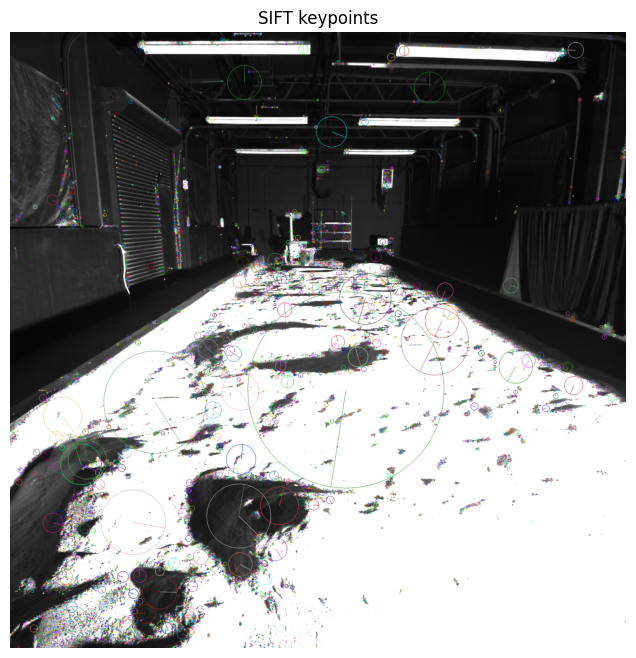

In [113]:
draw_keypoints_with_scale(cv2.imread("data/View1/Traverse1/00m/loc0_camL_150ms.png"), kp)

#### Keypoint Detection and Matching Between Two Images

In [114]:
def match_descriptors(des1, kp1, des2, kp2, ratio=0.75, ransac_thresh=5.0):

    # --- FLANN match ---
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=100)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    # --- Lowe ratio filtering ---
    good = [m for m, n in matches if m.distance < ratio * n.distance]

    # No RANSAC possible
    if len(good) < 4:
        return good, [], 0.0

    # --- Prepare data for RANSAC ---
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good])

    # --- RANSAC ---
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, ransac_thresh)

    if mask is None:
        return good, [], 0.0

    inliers = [m for m, inl in zip(good, mask.ravel()) if inl == 1]
    inlier_ratio = len(inliers) / len(good)

    return good, inliers, inlier_ratio


In [115]:
img1 = cv2.imread("data/View1/Traverse1/00m/loc0_camL_050ms.png")
img2 = cv2.imread("data/View1/Traverse1/00m/loc0_camL_150ms.png")

des1, kp1 = get_sift_descriptors(img1)
des2, kp2 = get_sift_descriptors(img2)

good, inliers, ratio = match_descriptors(des1, kp1, des2, kp2)

print("Good matches:", len(good))
print("Inliers:", len(inliers))
print("Inlier ratio:", ratio)

Good matches: 1366
Inliers: 1066
Inlier ratio: 0.780380673499268


In [116]:
def draw_inliers(img1, kp1, img2, kp2, inliers):
    inlier_img = cv2.drawMatches(
        img1, kp1,
        img2, kp2,
        inliers[:], None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    plt.figure(figsize=(14,7))
    plt.imshow(inlier_img, cmap='gray')
    plt.title(f"Inlier matches (SIFT) – {len(inliers)}")
    plt.axis('off')
    plt.show()


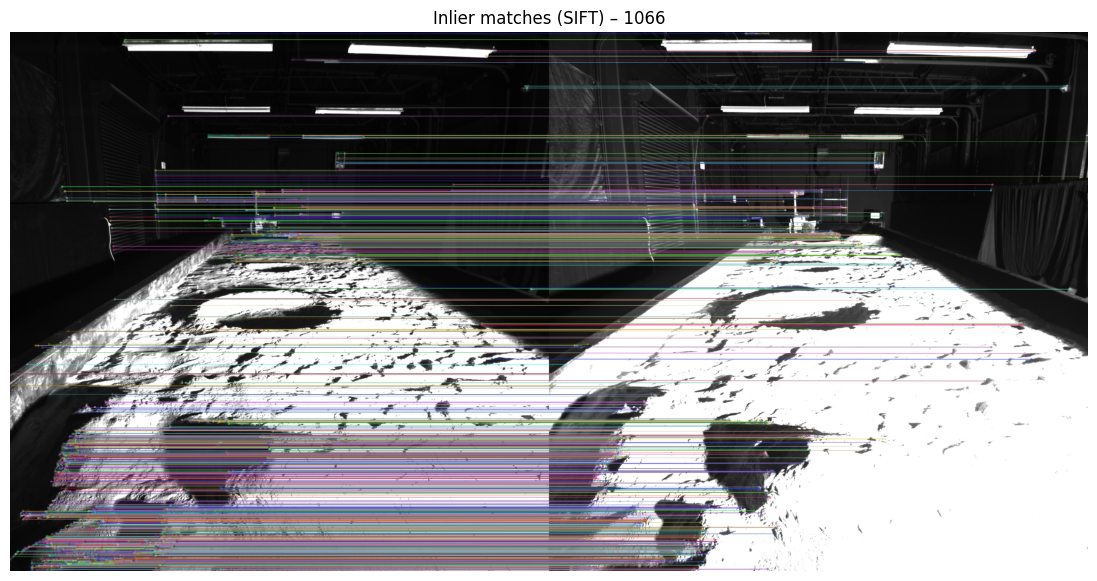

In [117]:
draw_inliers(img1, kp1, img2, kp2, inliers)

#### Defining a Unified Feature-Matching Pipeline Function

In [98]:
def sift_pipeline(img1, img2, ratio=0.75, ransac_thresh=5.0):

    # 1. SIFT keypoints + descriptors
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # 2. FLANN matching + Lowe ratio test 
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=100)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)
    good = [m for m, n in matches if m.distance < ratio * n.distance]

    if len(good) < 4:
        # RANSAC impossibile
        return kp1, kp2, des1, des2, good, [], 0.0, None

    #3. RANSAC geometric filtering 
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good])

    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, ransac_thresh)

    if mask is None:
        return kp1, kp2, des1, des2, good, [], 0.0, None

    inliers = [m for m, inl in zip(good, mask.ravel()) if inl == 1]
    inlier_ratio = len(inliers) / len(good) if len(good) > 0 else 0.0

    return kp1, kp2, des1, des2, good, inliers, inlier_ratio, H

In [99]:
img1 = cv2.imread("data/View1/Traverse1/00m/loc0_camL_050ms.png", 0)
img2 = cv2.imread("data/View1/Traverse1/00m/loc0_camL_150ms.png", 0)

kp1, kp2, des1, des2, good, inliers, ratio, H = sift_pipeline(img1, img2)

print("Matches:", len(good))
print("Inliers:", len(inliers))
print("Inlier ratio:", ratio)

Matches: 1367
Inliers: 1065
Inlier ratio: 0.7790782735918069


#### Analysis of the Experimental Results

##### Same Viewpoint and Illumination Variation

In [101]:
files_samelight1_view = sorted(glob.glob("data/View1/Traverse1/00m/loc0_camL_*.png"))

List_matches_view = []
List_inliners_view = []
List_inliners_ratio_view = []


for file1 in files_samelight1_view:
    for file2 in files_samelight1_view:
        img1 = cv2.imread(file1, 0)
        img2 = cv2.imread(file2,0)
        kp1, kp2, des1, des2, good, inliers, ratio, H = sift_pipeline(img1, img2)
        List_matches_view.append(len(good))
        List_inliners_view.append(len(inliers))
        List_inliners_ratio_view.append(ratio)

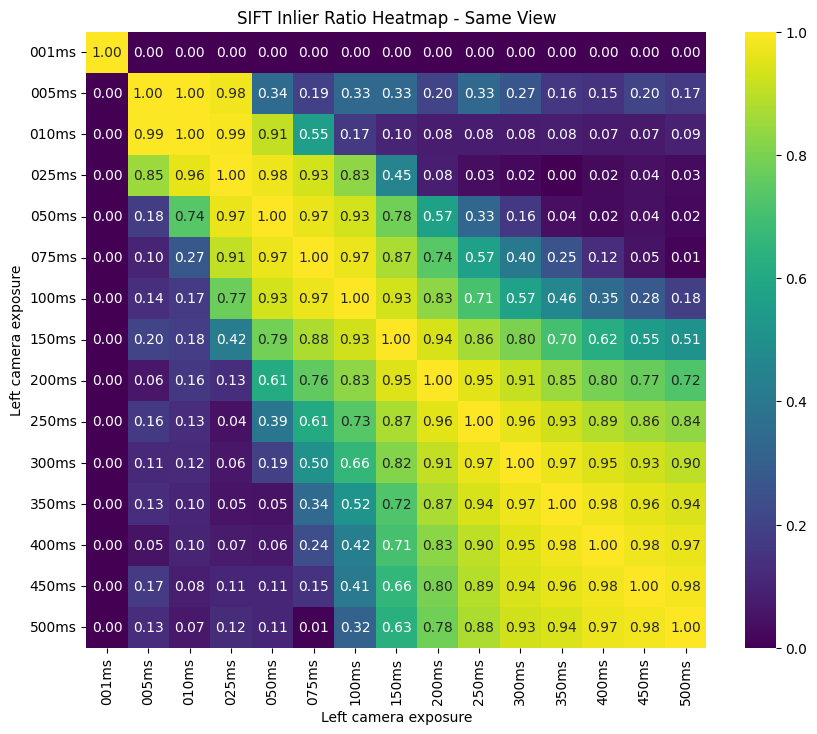

In [ ]:
N = len(files_samelight1_view)   # 15
M = len(files_samelight1_view)   # 15
heatmap = np.array(List_inliners_ratio_view).reshape(N, M)

import os

def get_exp(file):
    name = os.path.basename(file)
    return name.split("_")[-1].replace(".png", "")

labels_view = [get_exp(f) for f in files_samelight1_view]

import seaborn as sns

plt.figure(figsize=(10, 8))

sns.heatmap(
    heatmap,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    xticklabels=labels_view,
    yticklabels=labels_view,
    vmin=0,             
    vmax=1    
)

plt.xlabel("Left camera exposure")
plt.ylabel("Left camera exposure")
plt.title("SIFT Inlier Ratio Heatmap - Same View")
plt.show()

**Notes**
- Symmetric matrix: same camera on both axes.  
- Perfect diagonal: SIFT matches identical exposures.  
- Smooth degradation as exposure differences increase.  
- Very low exposures (001 ms) fail due to insufficient texture.


SIFT is highly stable for small exposure changes on the same camera, but fails at very low illumination.

##### Different viewpoint and different Illumination

In [ ]:
import glob

files_samelight1 = sorted(glob.glob("data/View1/Traverse1/00m/loc0_camL_*.png"))
files_samelight2 = sorted(glob.glob("data/View1/Traverse1/00m/loc1_camR_*.png"))

List_matches = []
List_inliners = []
List_inliners_ratio = []


for file1 in files_samelight1:
    for file2 in files_samelight2:
        img1 = cv2.imread(file1, 0)
        img2 = cv2.imread(file2,0)
        kp1, kp2, des1, des2, good, inliers, ratio, H = sift_pipeline(img1, img2)
        List_matches.append(len(good))
        List_inliners.append(len(inliers))
        List_inliners_ratio.append(ratio)

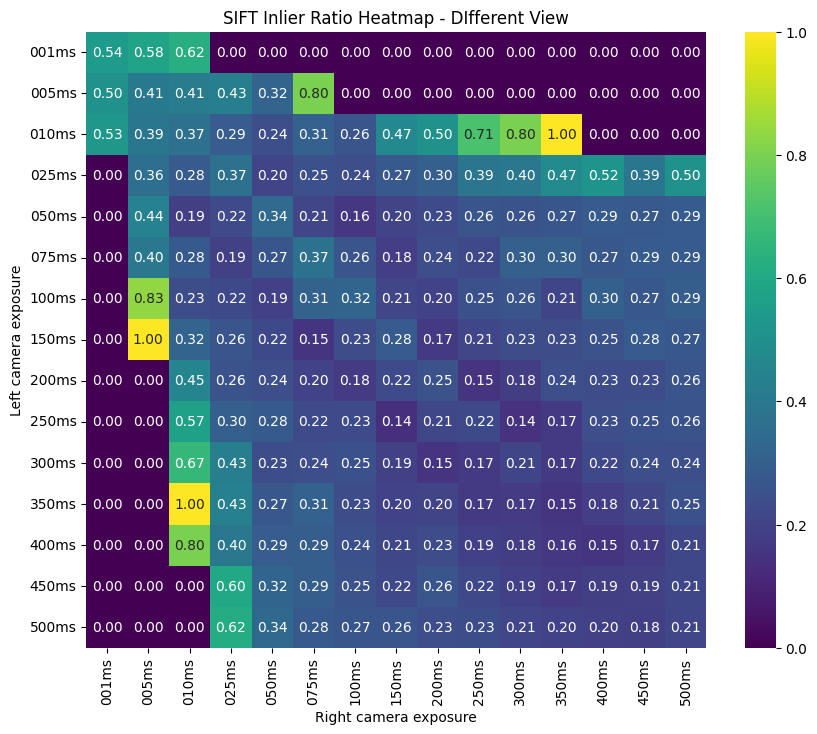

In [ ]:
N = len(files_samelight1)   # 15
M = len(files_samelight2)   # 15
heatmap = np.array(List_inliners_ratio).reshape(N, M)

import os

def get_exp(file):
    name = os.path.basename(file)
    return name.split("_")[-1].replace(".png", "")

labels_L = [get_exp(f) for f in files_samelight1]
labels_R = [get_exp(f) for f in files_samelight2]

import seaborn as sns

plt.figure(figsize=(10, 8))

sns.heatmap(
    heatmap,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    xticklabels=labels_R,
    yticklabels=labels_L,
    vmin=0,             
    vmax=1    
)

plt.xlabel("Right camera exposure")
plt.ylabel("Left camera exposure")
plt.title("SIFT Inlier Ratio Heatmap - DIfferent View")
plt.show()

**Notes**
- Two-camera comparison: camL (rows) vs camR (columns).  
- Matching depends mainly on exposure similarity, but overall performance is lower and less regular than the single-camera case.  
- Viewpoint differences and distinct shadow patterns reduce SIFT robustness across cameras.  

SIFT matching across the two cameras is strongly affected by both exposure differences and viewpoint variation, leading to lower and less consistent inlier ratios than in the single-camera case.

#### Conclusion

SIFT performs reliably under moderate illumination changes and provides stable geometric correspondences when the viewpoint varies.  
However, its performance degrades noticeably under extreme exposure differences, where gradients become weak and keypoints are harder to detect.  
Overall, SIFT offers strong geometric invariance but limited robustness to severe photometric changes.

## SuperPoint

### Theoretical Background: How SuperPoint Works

![a.png](img/SP_exp.png)

#### 1. Base detector (MagicPoint)
SuperPoint is first initialized using a simple convolutional detector called **MagicPoint**.  
MagicPoint is trained on a synthetic dataset of geometric shapes (triangles, quadrilaterals, ellipses, line intersections), where corner locations are known exactly.  
This allows supervised training of a corner heatmap with a standard cross-entropy loss.  
MagicPoint works well on clean synthetic shapes, but it is not robust enough on natural images.

#### 2. Homographic Adaptation
To adapt the detector to real images, SuperPoint uses **Homographic Adaptation**, a self-supervised procedure.  
Given an input image \(I\), multiple random homographies \(H_i\) are sampled and applied:

$$
I_i = H_i(I)
$$

MagicPoint predicts a corner heatmap on each warped image \(I_i\).  
Each prediction is then **unwarped** back to the original image using the inverse homography:

$$
H_i^{-1}\big(f_\theta(H_i(I))\big)
$$

All unwarped heatmaps are averaged to obtain a robust pseudo-ground-truth interest-point map:

$$
\hat{F}(I) = \frac{1}{N_h} \sum_{i=1}^{N_h} H_i^{-1}\big(f_\theta(H_i(I))\big)
$$

This aggregated map highlights keypoints that are stable under geometric transformations, providing labels for real images without manual annotation.

#### 3. SuperPoint training (detector + descriptor)

![a](img/SP_exp2.png)

Using the pseudo-ground-truth maps $\hat{F}(I)$, the full **SuperPoint** network is trained end-to-end.  
The architecture consists of an encoder and two heads:  
(i) an interest-point head that predicts a keypoint probability heatmap, and  
(ii) a descriptor head that outputs dense 256-dimensional descriptors.

The detector head is trained to reproduce $\hat{F}(I)$ with a cross-entropy loss.  
The descriptor head is trained so that corresponding points under a known homography have similar descriptors, while non-corresponding points are pushed apart.  
Given two images related by a homography \(H\), a point \(p\) in the first image corresponds to

$$
p' = H(p)
$$

and their descriptors are encouraged to satisfy

$$
d(p) \approx d(p') \, .
$$

#### Final result
After this training procedure, SuperPoint acts as a fully learned feature extractor that produces repeatable keypoints and robust 256-D descriptors in a single forward pass, with strong invariance to viewpoint, perspective and illumination changes.


### SuperPoint pipeline

#### SuperPoint: Feature Extraction and Matching

In [ ]:
from transformers import AutoImageProcessor, SuperPointForKeypointDetection
import torch
import cv2

img1 = cv2.imread("data/View1/Traverse1/00m/loc0_camL_050ms.png")

processor = AutoImageProcessor.from_pretrained("magic-leap-community/superpoint")
model = SuperPointForKeypointDetection.from_pretrained("magic-leap-community/superpoint")

inputs = processor(img1, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

h, w = img1.shape[:2]
image_size = (h, w)

processed_outputs = processor.post_process_keypoint_detection(outputs, [image_size])

c:\Users\Leo\Desktop\Personal_project_learn\IPM\projectpoint\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
processed_outputs

[{'keypoints': tensor([[ 323,   34],
          [ 176,   42],
          [ 252,   42],
          ...,
          [ 512, 2009],
          [1001, 2009],
          [1724, 2009]], dtype=torch.int32),
  'scores': tensor([0.0056, 0.0052, 0.0109,  ..., 0.0053, 0.0056, 0.1383]),
  'descriptors': tensor([[-0.0047, -0.1066,  0.1030,  ...,  0.0293,  0.0303, -0.0959],
          [-0.0364, -0.0144, -0.0174,  ..., -0.0003, -0.1183,  0.0406],
          [ 0.0014, -0.1511, -0.0346,  ...,  0.0051, -0.0553, -0.0365],
          ...,
          [-0.0221,  0.0679,  0.0421,  ..., -0.1424, -0.0380, -0.0803],
          [-0.0050,  0.0487, -0.0186,  ...,  0.1053,  0.0377, -0.0293],
          [ 0.1300, -0.1352,  0.0943,  ...,  0.0042, -0.0347,  0.0101]])}]

1056 keypoints find

In [ ]:
processed_outputs[0]["keypoints"].shape

torch.Size([1056, 2])

the first one have coordinates: [323,34]

In [ ]:
processed_outputs[0]["keypoints"][0]

tensor([323,  34], dtype=torch.int32)

Score for each keypoint, the higher the more confident the network is that it is a keypoint

In [ ]:
scores = processed_outputs[0]["scores"]
print(scores[:10])

tensor([0.0056, 0.0052, 0.0109, 0.1050, 0.1153, 0.1546, 0.1595, 0.0365, 0.1486,
        0.1292])


For each point I have a descriptor made of 1056 number

In [ ]:
processed_outputs[0]["descriptors"].shape

torch.Size([1056, 256])

I can plot the keypotins with relative score

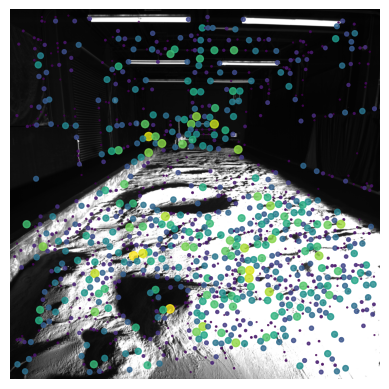

In [ ]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img1)
plt.scatter(
    processed_outputs[0]["keypoints"][:, 0],
    processed_outputs[0]["keypoints"][:, 1],
    c=processed_outputs[0]["scores"] * 100,
    s=processed_outputs[0]["scores"] * 50,
    alpha=0.8
)
plt.savefig(f"output_image.png")

#### SuperPoint Feature Extraction Function

In [ ]:
def superpoint_extract(img, processor, model):

    # Preprocess image
    inputs = processor(img, return_tensors="pt")

    # Forward pass (no gradients)
    with torch.no_grad():
        outputs = model(**inputs)

    # Restore original image size
    h, w = img.shape[:2]
    result = processor.post_process_keypoint_detection(outputs, [(h, w)])[0]

    # Extract tensors and convert to numpy
    keypoints    = result["keypoints"].cpu().numpy()
    scores       = result["scores"].cpu().numpy()
    descriptors  = result["descriptors"].cpu().numpy()

    return keypoints, scores, descriptors

In [ ]:
img1 = cv2.imread("data/View1/Traverse1/00m/loc0_camL_050ms.png")
img2 = cv2.imread("data/View1/Traverse1/00m/loc0_camL_100ms.png")

kp1, sc1, des1 = superpoint_extract(img1, processor, model)
kp2, sc2, des2 = superpoint_extract(img2, processor, model)

In [ ]:
print("kp1:", kp1.shape)
print("des1:", des1.shape)
print("kp2:", kp2.shape)
print("des2:", des2.shape)

kp1: (1056, 2)
des1: (1056, 256)
kp2: (1118, 2)
des2: (1118, 256)


#### Finding Corresponding Keypoints

In [ ]:
def match_descriptors_superpoint(kp1, des1, kp2, des2, ransac_thresh=5.0):
    """
    kp1, kp2: numpy arrays of shape (N, 2)
    des1, des2: numpy arrays of shape (N, 256)
    """

    # FLANN parameters for L2 matching
    index_params = dict(algorithm=1, trees=5)  # KD-tree
    search_params = dict(checks=100)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # KNN matching
    matches = flann.knnMatch(des1.astype(np.float32), des2.astype(np.float32), k=2)

    # Lowe ratio test
    good = [m for m, n in matches if m.distance < 0.75 * n.distance]

    # Need at least 4 matches for RANSAC
    if len(good) < 4:
        return good, [], 0.0

    # Extract point coordinates
    pts1 = np.float32([kp1[m.queryIdx] for m in good])
    pts2 = np.float32([kp2[m.trainIdx] for m in good])

    # RANSAC Homography
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, ransac_thresh)

    if mask is None:
        return good, [], 0.0

    inliers = [m for m, inl in zip(good, mask.ravel()) if inl == 1]
    inlier_ratio = len(inliers) / len(good)

    return good, inliers, inlier_ratio


In [ ]:
import numpy as np

good, inliers, ratio = match_descriptors_superpoint(kp1, des1, kp2, des2)
print(len(good), len(inliers), ratio)

585 445 0.7606837606837606


In [ ]:
def draw_inliers_superpoint(img1, kp1, img2, kp2, inliers):

    # Convert (x,y) -> cv2.KeyPoint
    cv_kp1 = [cv2.KeyPoint(float(x), float(y), 1) for (x, y) in kp1]
    cv_kp2 = [cv2.KeyPoint(float(x), float(y), 1) for (x, y) in kp2]

    # Draw inliers
    match_img = cv2.drawMatches(
        img1, cv_kp1,
        img2, cv_kp2,
        inliers,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure(figsize=(14, 7))
    plt.imshow(match_img)
    plt.title(f"Inlier matches (SuperPoint) – {len(inliers)}")
    plt.axis('off')
    plt.show()


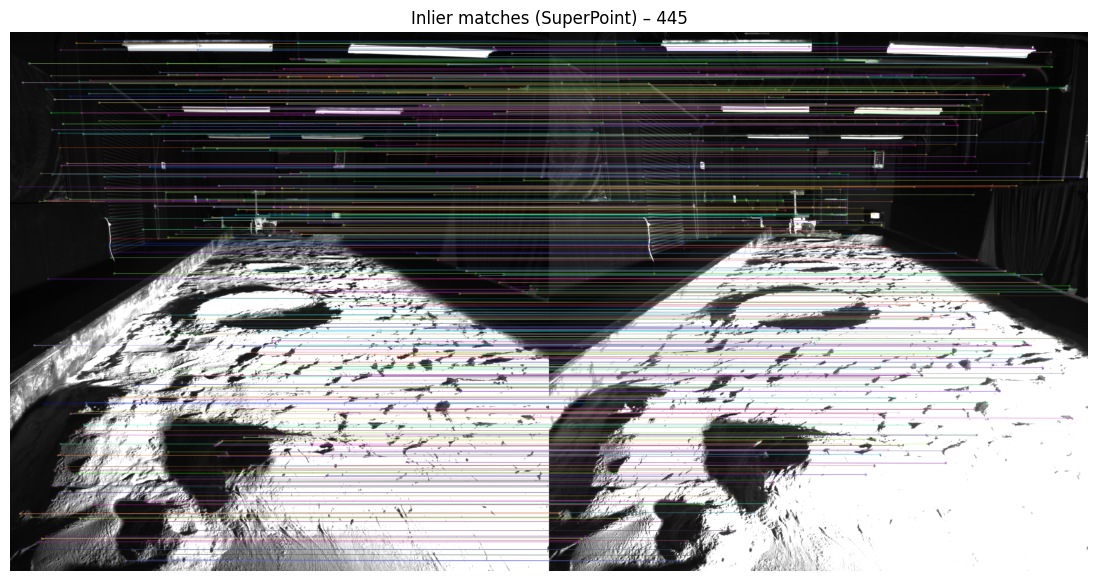

In [ ]:
draw_inliers_superpoint(img1, kp1, img2, kp2, inliers)

For this image pair, SIFT produces significantly more tentative matches and inliers than SuperPoint:

- SIFT: 1364 good matches, 1065 inliers (inlier ratio ≈ 0.78)  
- SuperPoint: 582 good matches, 453 inliers (inlier ratio ≈ 0.78)

Interestingly, the inlier ratio after RANSAC is almost identical for both methods, which means that, on this relatively easy pair, SuperPoint does not yet provide a clear advantage in terms of geometric consistency. It is, however, more selective and yields fewer matches overall.

A more meaningful comparison will come from:
- pairs with stronger illumination changes, and
- aggregated statistics (mean and standard deviation of the inlier ratio over many pairs),
rather than a single example.


#### Function to Execute the Full Feature Extraction and Matching Pipeline

In [ ]:
img1 = cv2.imread("data/View1/Traverse1/00m/loc0_camL_001ms.png")
img2 = cv2.imread("data/View1/Traverse1/00m/loc0_camL_001ms.png")

In [ ]:
def superpoint_pipeline(img1, img2, processor, model, ransac_thresh=5.0):

    kp1, sc1, des1 = superpoint_extract(img1, processor, model)
    kp2, sc2, des2 = superpoint_extract(img2, processor, model)

    good, inliers, inlier_ratio = match_descriptors_superpoint(
        kp1, des1, kp2, des2, ransac_thresh=ransac_thresh
    )

    return kp1, kp2, des1, des2, good, inliers, inlier_ratio


In [ ]:
kp1, kp2, des1, des2, good, inliers, ratio = superpoint_pipeline(
    img1, img2,
    processor,
    model
)

In [ ]:
print("Keypoints img1:", len(kp1))
print("Keypoints img2:", len(kp2))
print("Good matches:", len(good))
print("Inliers:", len(inliers))
print("Inlier ratio:", ratio)


Keypoints img1: 143
Keypoints img2: 143
Good matches: 143
Inliers: 143
Inlier ratio: 1.0


#### Analysis of the Experimental Results


#### Same viewpoint, different Illumination

In [ ]:
import glob

files_samelight1_view = sorted(glob.glob("data/View1/Traverse1/00m/loc0_camL_*.png"))

List_matches_view = []
List_inliers_view = []
List_inliers_ratio_view = []

for file1 in files_samelight1_view:
    for file2 in files_samelight1_view:

        img1 = cv2.imread(file1)
        img2 = cv2.imread(file2)

        kp1, kp2, des1, des2, good, inliers, ratio = superpoint_pipeline(
            img1, img2,
            processor,
            model
        )

        List_matches_view.append(len(good))
        List_inliers_view.append(len(inliers))
        List_inliers_ratio_view.append(ratio)


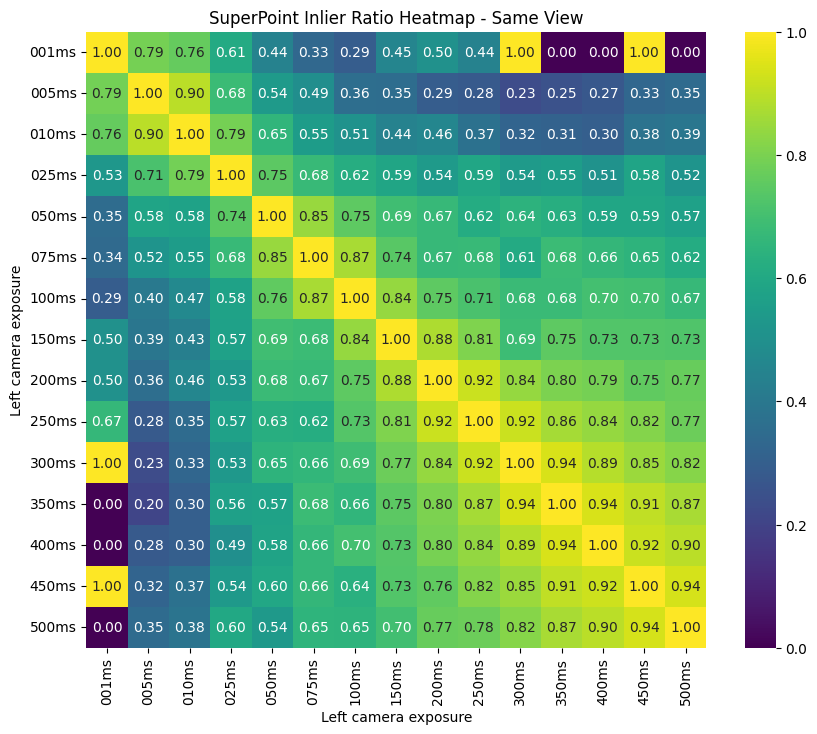

In [ ]:
N = len(files_samelight1_view)   # 15
M = len(files_samelight1_view)   # 15
heatmap = np.array(List_inliers_ratio_view).reshape(N, M)

import os

def get_exp(file):
    name = os.path.basename(file)
    return name.split("_")[-1].replace(".png", "")

labels_view = [get_exp(f) for f in files_samelight1_view]

import seaborn as sns

plt.figure(figsize=(10, 8))

sns.heatmap(
    heatmap,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    xticklabels=labels_view,
    yticklabels=labels_view,
    vmin=0,             
    vmax=1    
)

plt.xlabel("Left camera exposure")
plt.ylabel("Left camera exposure")
plt.title("SuperPoint Inlier Ratio Heatmap - Same View")
plt.show()

This heatmap shows that SuperPoint is highly robust to illumination changes when the viewpoint remains fixed.  
Most exposure pairs achieve inlier ratios between **0.70 and 0.90**, demonstrating good photometric invariance.  
The diagonal is consistently strong (as expected), but importantly the off-diagonal regions also remain relatively high, indicating that SuperPoint can match features even when exposure differences are large (e.g., 050ms ↔ 300ms or 100ms ↔ 400ms).

However, a few exposure combinations at the lowest illumination levels produce very weak matches (values near 0.0), likely due to SuperPoint failing to detect enough keypoints in extremely dark images.

Overall, this result confirms that **SuperPoint provides significantly better robustness to illumination variation than SIFT**, especially in mid- to high-exposure ranges, making it well suited for environments with strong photometric variability such as lunar shadow transitions.


#### Different viewpoint, different Illumination

In [ ]:
files_samelight1 = sorted(glob.glob("data/View1/Traverse1/00m/loc0_camL_*.png"))
files_samelight2 = sorted(glob.glob("data/View1/Traverse1/00m/loc1_camR_*.png"))

List_matches = []
List_inliners = []
List_inliners_ratio = []


for file1 in files_samelight1:
    for file2 in files_samelight2:
        img1 = cv2.imread(file1)
        img2 = cv2.imread(file2)
        kp1, kp2, des1, des2, good, inliers, ratio = superpoint_pipeline(
            img1, img2,
            processor,
            model
        )
        List_matches.append(len(good))
        List_inliners.append(len(inliers))
        List_inliners_ratio.append(ratio)

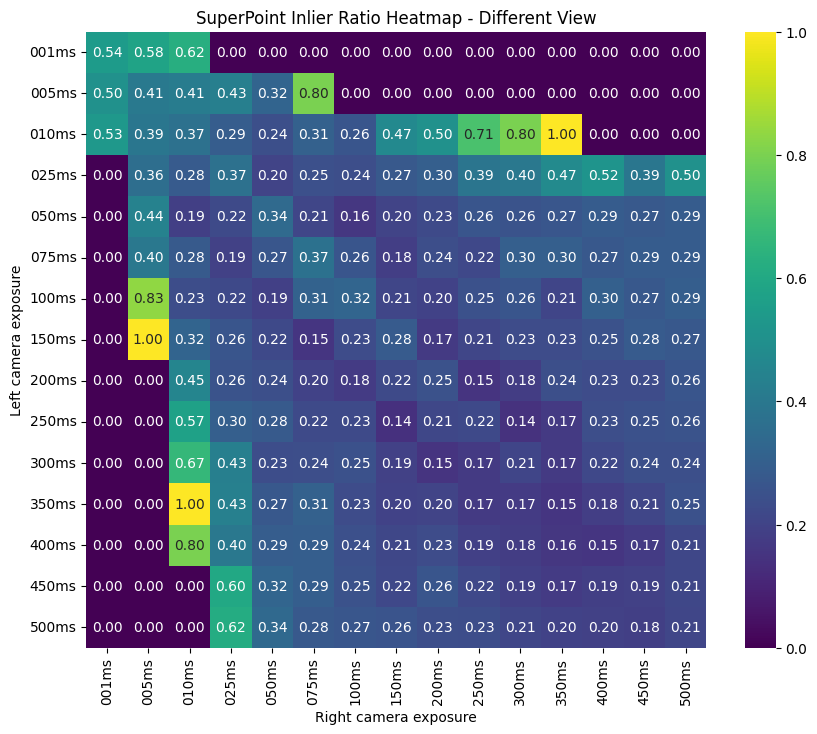

In [ ]:
N = len(files_samelight1)   # 15
M = len(files_samelight2)   # 15
heatmap = np.array(List_inliners_ratio).reshape(N, M)

import os

def get_exp(file):
    name = os.path.basename(file)
    return name.split("_")[-1].replace(".png", "")

labels_L = [get_exp(f) for f in files_samelight1]
labels_R = [get_exp(f) for f in files_samelight2]

import seaborn as sns

plt.figure(figsize=(10, 8))

sns.heatmap(
    heatmap,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    xticklabels=labels_R,
    yticklabels=labels_L,
    vmin=0,             
    vmax=1    
)

plt.xlabel("Right camera exposure")
plt.ylabel("Left camera exposure")
plt.title("SuperPoint Inlier Ratio Heatmap - Different View")
plt.show()

In this scenario, where both viewpoint and illumination vary, SuperPoint shows a clear degradation in robustness compared to the same-viewpoint case.  
Most inlier ratios fall in the **0.20–0.35** range, indicating that the learned descriptors struggle to maintain consistency under geometric changes.  

Overall, the heatmap highlights that **SuperPoint is highly sensitive to viewpoint variations**, and its strong illumination robustness does not transfer to geometric invariance.  
This explains why performance drops sharply when both lighting and viewpoint differ, as expected from a model not explicitly trained for wide-baseline matching.


#### Conclusion

SuperPoint demonstrates strong robustness to illumination changes when the viewpoint is fixed, consistently achieving high inlier ratios across a wide range of exposure differences.  
However, when viewpoint variation is introduced, its performance drops sharply, indicating limited geometric invariance.  
Overall, SuperPoint is less reliable for scenarios involving significant viewpoint changes.

## SuperPoint + SuperGlue

### Theoretical Background: How SuperGlue Works

![{EB83AEEB-B329-4907-AFD3-94FB566C4410}.png](img/SG_exp.png)

#### 1. Attentional Graph Neural Network  
SuperGlue introduces a learned feature matcher that operates on top of keypoints and descriptors (commonly extracted by SuperPoint, but compatible with any detector/descriptor).  
Its core component is an **Attentional Graph Neural Network (GNN)** that jointly reasons about all keypoints in both images.

Each keypoint is described by its descriptor $d_i$ and spatial location $p_i$.  
These are fused together by a **Keypoint Encoder**, which produces enriched feature vectors that combine appearance, geometry, and keypoint confidence.

The GNN consists of multiple alternating attention layers:

- **Self-Attention**  
  Keypoints within the *same image* communicate with each other.  
  This step helps capture geometric context (edges, corners, structured patterns) and suppresses ambiguous or isolated points.

- **Cross-Attention**  
  Keypoints from image A attend to those in image B and vice versa.  
  This allows the network to reason jointly about potential correspondences across images, rather than relying purely on descriptor similarity.

After several rounds of self- and cross-attention, each keypoint is transformed into a **context-aware embedding** that encodes its appearance, geometric context, and likely correspondences.

#### 2. Matching Score Matrix  
Once the enriched embeddings are obtained, SuperGlue computes a **pairwise score matrix**  

$$
S_{i,j} = f^A_i \cdot f^B_j ,
$$

where $f^A_i$ and $f^B_j$ are the final embeddings of keypoint $i$ in image A and keypoint $j$ in image B.  
This score reflects how likely the two keypoints correspond.

A special “dustbin” row and column are added to $S$ to allow keypoints to remain unmatched—important for scenes with occlusion, differing viewpoints, or spurious detections.


#### 3. Optimal Matching via Sinkhorn Normalization  
Instead of simply taking nearest neighbors in descriptor space, SuperGlue formulates matching as a **differentiable optimal assignment problem**.

The score matrix $S$ is converted into a **doubly-stochastic matrix** $P$ using the Sinkhorn algorithm.  
Sinkhorn alternates row and column normalizations until the matrix behaves like a soft permutation matrix:

- each row sums to 1 → each keypoint in A selects exactly one match (or dustbin)  
- each column sums to 1 → each keypoint in B is matched at most once  

After convergence, the resulting matrix $P$ approximates a binary matching:

- $P_{i,j} \approx 1$ → keypoint $i$ matches keypoint $j$  
- $P_{i,j} \approx 0$ → no match  
- dustbin entry → keypoint rejected  

This approach ensures globally consistent, one-to-one correspondences, something traditional matching methods cannot guarantee.

#### 4. Training Objective  
SuperGlue is trained on pairs of images with known relative geometry (e.g., from synthetic views or RGB-D datasets).  
Ground-truth correspondences are used to supervise the Sinkhorn-normalized matrix.  
The training loss encourages:

- high scores for true correspondences  
- low scores for incorrect ones  
- correct use of the dustbin for unmatched points  

The entire network—including attention layers and matching layer—is trained end-to-end.

#### 5. Final Result  
After training, SuperGlue becomes a powerful learned matcher that significantly outperforms classical methods such as FLANN or BFMatcher.  
It leverages global context, cross-image reasoning, and optimal assignment to produce stable, accurate correspondences.

SuperGlue is especially robust under:

- viewpoint and perspective changes  
- illumination variations  
- repetitive patterns  
- partial occlusions  
- low-texture or noisy environments  

This makes it highly effective for applications in robotics, SLAM, visual odometry, 3D reconstruction, and Earth Observation.


### SuperPoint + SuperGlue pipeline

##### Keypoint Extraction and Image-to-Image Matching


In [ ]:
from transformers import pipeline
from PIL import Image
import numpy as np

def superpoint_superglue(img1, img2, threshold=0.3):

    matcher = pipeline(
        task="keypoint-matching",
        model="magic-leap-community/superglue_outdoor"
    )

    if isinstance(img1, np.ndarray):
        img1 = Image.fromarray(img1)
    if isinstance(img2, np.ndarray):
        img2 = Image.fromarray(img2)

    results = matcher([img1, img2], threshold=threshold)

    kp1 = []
    kp2 = []
    matches = []
    scores = []

    for idx, r in enumerate(results):
        x0, y0 = float(r["keypoint_image_0"]["x"]), float(r["keypoint_image_0"]["y"])
        x1, y1 = float(r["keypoint_image_1"]["x"]), float(r["keypoint_image_1"]["y"])
        score = float(r["score"])

        kp1.append([x0, y0])
        kp2.append([x1, y1])
        matches.append([idx, idx])  
        scores.append(score)

    return {
        "keypoints0": np.array(kp1),
        "keypoints1": np.array(kp2),
        "matches": np.array(matches),   # Nx2 array
        "scores": np.array(scores),
        "img1": np.array(img1),
        "img2": np.array(img2)
    }


In [ ]:
import numpy as np
import cv2

def find_inliers_superglue(res, ransac_thresh=5.0):

    kp1 = res["keypoints0"]
    kp2 = res["keypoints1"]
    matches = res["matches"]

    if len(matches) < 4:
        return [], matches, 0.0, None

    pts1 = np.float32([kp1[i0] for (i0, _) in matches])
    pts2 = np.float32([kp2[i1] for (_, i1) in matches])

    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, ransac_thresh)

    if H is None:
        return [], matches, 0.0, None

    mask = mask.ravel().astype(bool)

    inlier_matches = [m for m, inl in zip(matches, mask) if inl]
    outlier_matches = [m for m, inl in zip(matches, mask) if not inl]

    inlier_ratio = len(inlier_matches) / len(matches)

    return inlier_matches, outlier_matches, inlier_ratio, H


In [ ]:
def visualize_inliers(img1, img2, kp1, kp2, inliers):

    import matplotlib.pyplot as plt
    import numpy as np

    H = max(img1.shape[0], img2.shape[0])
    W = img1.shape[1] + img2.shape[1]
    canvas = np.zeros((H, W, 3), dtype=np.uint8)
    canvas[:img1.shape[0], :img1.shape[1]] = img1
    canvas[:img2.shape[0], img1.shape[1]:] = img2

    plt.figure(figsize=(15, 10))
    plt.imshow(canvas)
    plt.axis("off")

    shift = img1.shape[1]

    for pair in inliers:
        i0, i1 = int(pair[0]), int(pair[1])
        x0, y0 = kp1[i0]
        x1, y1 = kp2[i1]
        plt.plot([x0, x1 + shift], [y0, y1], linewidth=0.8)

    plt.title("Inliners Matches(SuperPoint+SuperGlue) - 554")
    plt.show()


Device set to use cpu


SuperGlue matches: 738
Inliers: 554
Inlier ratio: 0.7506775067750677


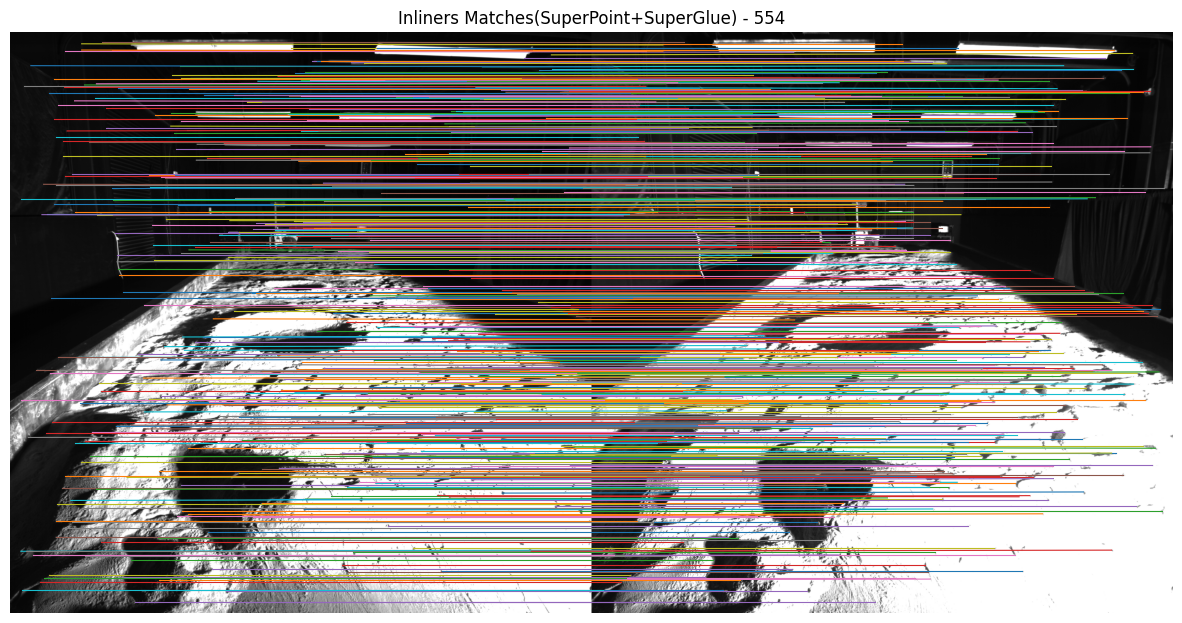

In [ ]:
import cv2

img1 = cv2.imread("data/View1/Traverse1/00m/loc0_camL_050ms.png")
img2 = cv2.imread("data/View1/Traverse1/00m/loc0_camL_100ms.png")

# MATCHING
res = superpoint_superglue(img1, img2, threshold=0.3)
print("SuperGlue matches:", len(res["matches"]))

# RANSAC
inliers, outliers, inlier_ratio, H = find_inliers_superglue(res)
print("Inliers:", len(inliers))
print("Inlier ratio:", inlier_ratio)

visualize_inliers(res["img1"], res["img2"], res["keypoints0"], res["keypoints1"], inliers)


#### Evaluation of the SuperGlue Matching Performance

In [ ]:
import glob
import seaborn as sns
import matplotlib.pyplot as plt

files_samelight1 = sorted(glob.glob("data/View1/Traverse1/00m/loc0_camL_*.png"))
files_samelight2 = sorted(glob.glob("data/View1/Traverse1/00m/loc1_camR_*.png"))

##### Same View, different Illumination

In [ ]:
List_inliers_ratio_view = []

for file1 in files_samelight1:
    for file2 in files_samelight1:

        img1 = cv2.imread(file1)
        img2 = cv2.imread(file2)

        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

        # SuperGlue
        res = superpoint_superglue(img1, img2, threshold=0.3)

        # RANSAC
        inliers, outliers, ratio, H = find_inliers_superglue(res)

        List_inliers_ratio_view.append(ratio)


Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set

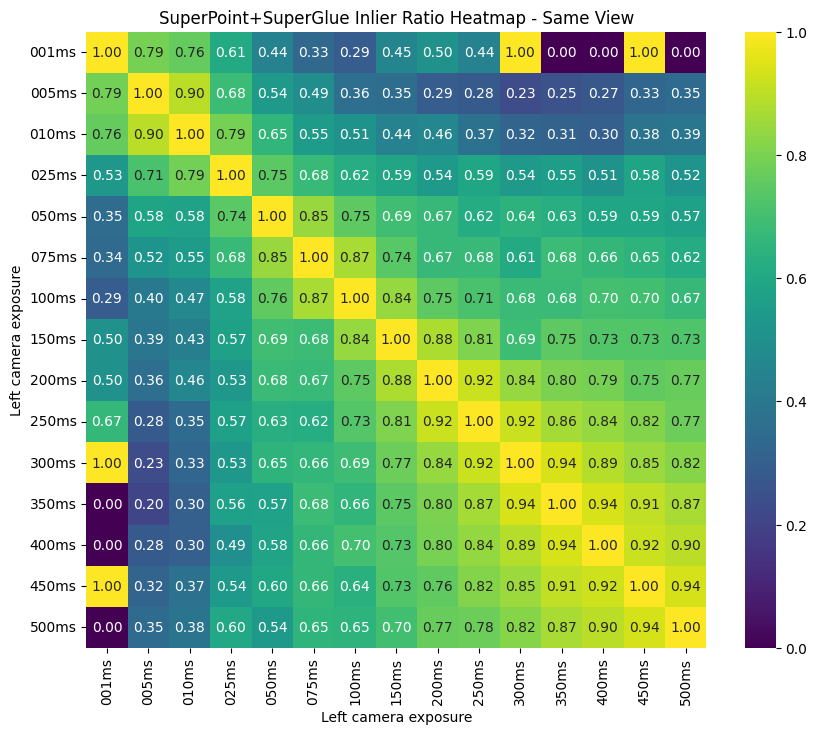

In [ ]:
N = len(files_samelight1) 
M = len(files_samelight1)  

heatmap = np.array(List_inliers_ratio_view).reshape(N, M)

def get_exp(file):
    name = os.path.basename(file)
    return name.split("_")[-1].replace(".png", "")

labels_view = [get_exp(f) for f in files_samelight1]

plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    xticklabels=labels_view,
    yticklabels=labels_view,
    vmin=0,             
    vmax=1    
)
plt.xlabel("Left camera exposure")
plt.ylabel("Left camera exposure")
plt.title("SuperPoint+SuperGlue Inlier Ratio Heatmap - Same View")
plt.show()


##### Different View, different Illumination

In [ ]:
List_matches = []
List_inliers = []
List_inliers_ratio = []

for file1 in files_samelight1:
    for file2 in files_samelight2:
        
        img1 = cv2.imread(file1)
        img2 = cv2.imread(file2)
        
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

        res = superpoint_superglue(img1, img2, threshold=0.3)

        total_matches = len(res["matches"])

        inliers, outliers, ratio, H = find_inliers_superglue(res)

        List_matches.append(total_matches)
        List_inliers.append(len(inliers))
        List_inliers_ratio.append(ratio)

Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set

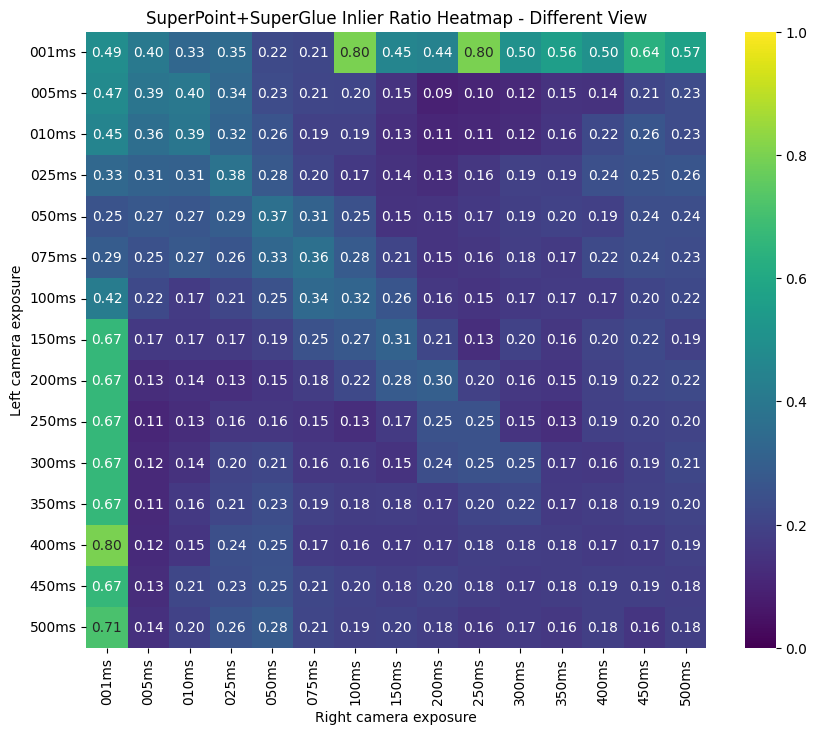

In [ ]:
import os

N = len(files_samelight1)  
M = len(files_samelight2)   
heatmap = np.array(List_inliers_ratio).reshape(N, M)

def get_exp(file):
    name = os.path.basename(file)
    return name.split("_")[-1].replace(".png", "")

labels_L = [get_exp(f) for f in files_samelight1]
labels_R = [get_exp(f) for f in files_samelight2]

import seaborn as sns

plt.figure(figsize=(10, 8))

sns.heatmap(
    heatmap,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    xticklabels=labels_R,
    yticklabels=labels_L,
    vmin=0,             
    vmax=1            
)

plt.xlabel("Right camera exposure")
plt.ylabel("Left camera exposure")
plt.title("SuperPoint+SuperGlue Inlier Ratio Heatmap - Different View")
plt.show()

## Conclusion

|                           | Same viewpoint, different Illumination                | Different viewpoint, different Illumination           |
|---------------------------|-----------------------------------------------|-----------------------------------------------|
| **SIFT**                  | ![imagee-5.png](img/SIFT.png)         | ![imagee-6.png](img/SIFT_diff.png)         |
| **SuperPoint**            | ![imagee-4.png](img/SuperPoint.png)         | ![imagee-3.png](img/SuperPoint_diff.png)         |
| **SuperPoint + SuperGlue**| ![imagee-2.png](img/SuperGlue.png)         | ![imagee.png](img/SuperGlue_diff.png)             |

### Analysis of Results: SIFT vs. SuperPoint vs. SuperPoint+SuperGlue

The comparative analysis of the inlier-ratio heatmaps highlights how different feature extraction and matching pipelines behave under varying illumination and viewpoint conditions. The patterns are consistent with the literature and reveal the trade-offs that characterize each method.

---

#### 1. Same Viewpoint, Different Illumination

##### SIFT
- Shows stable performance across moderate illumination changes.
- Degrades gradually under darker exposures due to reduced gradient information.
- Produces a clear diagonal with inlier ratios typically between 0.6 and 1.0.

**Interpretation:**  
SIFT is reasonably robust to lighting variation, but its performance decreases noticeably under extreme low-light conditions.

##### SuperPoint
- More robust to illumination changes than SIFT.
- Maintains higher inlier ratios across large exposure differences.
- Shows a wider region of strong matching performance.

**Interpretation:**  
SuperPoint’s learned features generalize well to photometric changes, outperforming classical descriptors in this scenario.

##### SuperPoint + SuperGlue
- Provides the strongest overall performance in the same-view setting.
- Heatmaps are more uniform and consistently show high inlier ratios.
- SuperGlue improves match consistency and reduces noise.

**Interpretation:**  
SuperGlue compensates for SuperPoint’s weaknesses and creates a highly stable matching pipeline when viewpoint remains fixed.

---

#### 2. Different Viewpoint, Different Illumination

This represents the most challenging condition, combining geometric and photometric variation.

##### SIFT
- Performs better than both deep-learning-based pipelines.
- Maintains a moderate but stable number of inliers despite significant viewpoint change.
- Heatmaps remain structured and comparatively stronger.

**Interpretation:**  
SIFT’s handcrafted design provides solid geometric invariance, making it robust against perspective distortions.

##### SuperPoint
- Experiences the strongest degradation.
- Inlier ratios often fall into the 0.1–0.3 range.
- Suffers from viewpoint-induced appearance variations.

**Interpretation:**  
SuperPoint is not inherently viewpoint-invariant, and illumination change amplifies this limitation.

##### SuperPoint + SuperGlue
- Improves significantly over SuperPoint alone.
- Still does not surpass SIFT in challenging viewpoint differences.
- Delivers cleaner heatmaps but lower absolute inlier ratios than SIFT.

**Interpretation:**  
SuperGlue enhances matching quality, but cannot fully compensate for SuperPoint’s limited geometric invariance.

---

#### 3. Overall Summary

No single method is optimal in all situations.

- SIFT is the most robust to viewpoint changes.
- SuperPoint is the most robust to illumination changes.
- SuperGlue provides a substantial improvement when viewpoint remains similar.
- In mixed conditions, SuperPoint + SuperGlue approaches SIFT’s performance but does not exceed it.

The choice of method should depend on the operational scenario:
- Illumination variability: SuperPoint or SuperPoint + SuperGlue
- Large viewpoint shifts: SIFT
- Combined moderate changes: SuperPoint + SuperGlue